# Benchmarking the code for analysis with artificial data

created 2025-03-26, by Kananovich
updated 2025-04-17 by Kananovich

In [1]:
import numpy as np
import scipy.stats as sts
from scipy import constants as cnst
import pandas as pd
from matplotlib import pyplot as plt

general parameters.
camera resolution updated on 2025-04-17 using the data provided by Parth

In [233]:
nP = 1000 #number of particles
rho = 1510.0
dust_diam = 7.14E-6
fps = 1.0E10 # camera framerate in frames per second
#fps = 295.0 # camera framerate in frames per second
time_step = 1.0 / fps
res_meters_per_px = 30.0E-20
#res_meters_per_px = 30E-6
resol_SI = 1.0 / res_meters_per_px # camera resolution in px/meters
dust_mass = 4.0 / 3.0 * np.pi * (dust_diam / 2.0)**3 * rho #mass of the dust particles
kin_Tx = 1000.0 #kinetic temperature (in Kelvins) along the x axis
kin_Ty = 1000.0 #kinetic temperature (in Kelvins) along the y axis
drift_x = 0  # asuming the average x-component of the particles is zero (no drift)
left_x_bord = 0
right_x_bord = 1751.0 # right border of the field of view in pixels
left_x_bord_SI = left_x_bord / resol_SI
right_x_bord_SI = right_x_bord / resol_SI #coordinated of the right border
    #of the filed of view in meters


In [3]:
resol_SI

3.3333333333333335e+18

## Step 1. Creating an array of artificial velocities

In [4]:
arr_ind = np.arange(0,nP,1,dtype = 'int') # array of particles ID numbers

In [5]:
sigma_x = np.sqrt(cnst.k * kin_Tx / dust_mass)

In [6]:
sigma_x

0.00021903148058823087

In [7]:
art_vx_rv = sts.norm(drift_x,sigma_x)
arr_sample_vx = art_vx_rv.rvs(nP)

## Step 2. Creating an array of artificial coordinates

In [8]:
art_x_prev_rv = sts.uniform(left_x_bord_SI, right_x_bord_SI - left_x_bord_SI)
arr_sample_prev_x = art_x_prev_rv.rvs(nP)


In [9]:
arr_prev_x_inResolChunks = arr_sample_prev_x * resol_SI

In [10]:
arr_prev_x_inResolChunks_int = arr_prev_x_inResolChunks.astype(int)

In [11]:
arr_rough_prev_x = arr_prev_x_inResolChunks_int.astype('float64') / resol_SI


## Step 3. Creating an array of artificial coordinates for the "next frame"

In [12]:
arr_next_x = arr_rough_prev_x + arr_sample_vx * time_step

In [13]:
arr_next_x_inResolChunks = arr_next_x * resol_SI
arr_next_x_inResolChunks_int = arr_next_x_inResolChunks.astype('int64')
arr_rough_next_x = arr_next_x_inResolChunks_int.astype('float64') / resol_SI

## Step 4. Calculating the restored velocities

In [14]:
arr_vx_restored = (arr_rough_next_x - arr_rough_prev_x) / time_step

## Step 5. Calculating the array of discrepancies

In [15]:
arr_discrep_x = np.abs(arr_vx_restored - arr_sample_vx)

In [16]:
arr_frac_discrep_x = np.abs(arr_discrep_x / arr_sample_vx) * 100

In [17]:
arr_frac_discrep_x.min()

2.5881810864227027e-06

In [18]:
arr_frac_discrep_x.max()

0.13749412538010675

In [19]:
arr_frac_discrep_x.mean()

0.0031373405157319265

In [210]:
def create_art_vels(tTx, tTy, N_particles, metersPerPx, frps, ro, diam, drift_x, drift_y, left_x, right_x, lefty, right_y):
    import numpy as np
    import scipy.stats as sts
    from scipy import constants as cnst
    resol_SI = 1.0 / metersPerPx # camera resolution in px/meters
   
    dust_mass = 4.0 / 3.0 * np.pi * (diam / 2.0)**3 * ro #mass of the dust particles
    sigma_x = np.sqrt(cnst.k * tTx / dust_mass)
    sigma_y = np.sqrt(cnst.k * tTy / dust_mass)
    left_x_bord_SI = left_x / resol_SI
    right_x_bord_SI = right_x / resol_SI #coordinated of the right border
    time_step = 1.0 / frps


    #Creating the arrays to store data in:
    arr_ind = np.arange(0,N_particles,1,dtype = 'int') # array of particles ID numbers
    arr_first_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_first_frame_no = arr_first_frame_no + int(1)        #array to store the frist frame number
    arr_next_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_next_frame_no = arr_next_frame_no + int(2)        #array to store the frist frame number

    #array to store the "nonexistent" data:

    arr_nan = np.empty(N_particles)
    arr_nan.fill(np.nan)
    
    

    artif_vx_rv = sts.norm(drift_x,sigma_x)
    arr_sample_vx = artif_vx_rv.rvs(N_particles)

    #Array of artificial coordinates for the "previous" frame:
    art_x_prev_rv = sts.uniform(left_x_bord_SI, right_x_bord_SI - left_x_bord_SI)
    arr_sample_prev_x = art_x_prev_rv.rvs(N_particles)

    arr_prev_x_inResolChunks = arr_sample_prev_x * resol_SI
    arr_prev_x_inResolChunks_int = arr_prev_x_inResolChunks.astype(int)
    arr_rough_prev_x = arr_prev_x_inResolChunks_int.astype('float64') / resol_SI
    
    ## Step 3. Creating an array of artificial coordinates for the "next frame"
    arr_next_x = arr_rough_prev_x + arr_sample_vx * time_step
    arr_next_x_inResolChunks = arr_next_x * resol_SI
    arr_next_x_inResolChunks_int = arr_next_x_inResolChunks.astype('int64')
    arr_rough_next_x = arr_next_x_inResolChunks_int.astype('float64') / resol_SI

## Step 4: Calculating the "restored" velocities:
    arr_vx_restored = (arr_rough_next_x - arr_rough_prev_x) / time_step

    #saving all the data in the output dataframe:
    
    #first, create a dataframe storing the data of the first 'video frame':
    
    dataFirstFrame = {'particle':arr_ind, 'frame':arr_first_frame_no, 'x': arr_rough_prev_x, 'vx':arr_vx_restored, 'real_vx': arr_sample_vx}
    first_df = pd.DataFrame(dataFirstFrame)
    
    #the same for the next video frame:

    dataNextFrame = {'particle':arr_ind, 'frame':arr_next_frame_no, 'x': arr_rough_next_x, 'vx':arr_nan, 'real_vx': arr_nan}
    next_df = pd.DataFrame(dataNextFrame)
    
    ret_df = pd.concat([first_df,next_df], ignore_index = True)
    return ret_df
df = create_art_vels(1200, 1200, 1000, 1.0E-8, 100, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
df

,particle,frame,x,vx,real_vx
0,0,1,1.318000e-05,0.000165,0.000165
1,1,1,2.930000e-06,-0.000190,-0.000190
2,2,1,3.070000e-06,-0.000026,-0.000025
3,3,1,1.820000e-06,0.000321,0.000322
4,4,1,5.590000e-06,-0.000082,-0.000081
...,...,...,...,...,...
1995,995,2,3.200000e-07,NaN,NaN
1996,996,2,2.500000e-07,NaN,NaN
1997,997,2,1.349000e-05,NaN,NaN
1998,998,2,5.760000e-06,NaN,NaN


In [211]:
df_first = df[df['frame'] == 1]
arr_vxTheor = np.array(df_first['real_vx'])

<BarContainer object of 19 artists>

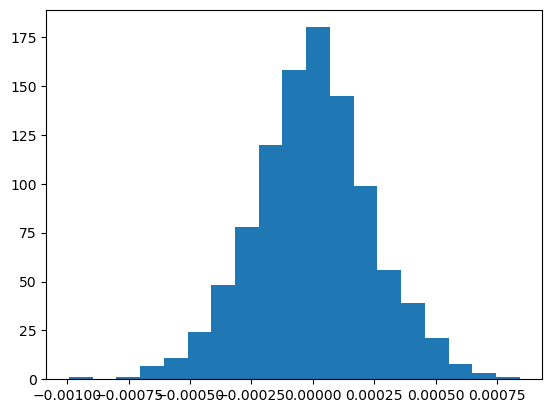

In [212]:
counts_xt, bins_xt = np.histogram(arr_vxTheor, bins = 19)
fig_x, ax_x = plt.subplots()
arr_bins_centers = 0.5 * (bins_xt[1:] + bins_xt[:-1])
ax_x.bar(arr_bins_centers, counts_xt, width = (arr_bins_centers[1] - arr_bins_centers[0]))

In [213]:
bins_x = arr_bins_centers - 0.5 * (arr_bins_centers[1] - arr_bins_centers[0])

In [214]:
bins_x = np.append(bins_x, bins_x[-1] + (bins_x[1] - bins_x[0]))

In [215]:
arr_vx = np.array(df_first['vx'])
counts_xe, bins_xe = np.histogram(arr_vx, bins = bins_x)
#counts_xe, bins_xe = np.histogram(arr_vx, bins = 100)

In [216]:
bins_xe

array([-9.93158170e-04, -8.96561717e-04, -7.99965264e-04, -7.03368811e-04,
       -6.06772358e-04, -5.10175904e-04, -4.13579451e-04, -3.16982998e-04,
       -2.20386545e-04, -1.23790092e-04, -2.71936386e-05,  6.94028146e-05,
        1.65999268e-04,  2.62595721e-04,  3.59192174e-04,  4.55788627e-04,
        5.52385080e-04,  6.48981534e-04,  7.45577987e-04,  8.42174440e-04])

In [217]:
bins_xt

array([-9.93158170e-04, -8.96561717e-04, -7.99965264e-04, -7.03368811e-04,
       -6.06772358e-04, -5.10175904e-04, -4.13579451e-04, -3.16982998e-04,
       -2.20386545e-04, -1.23790092e-04, -2.71936386e-05,  6.94028146e-05,
        1.65999268e-04,  2.62595721e-04,  3.59192174e-04,  4.55788627e-04,
        5.52385080e-04,  6.48981534e-04,  7.45577987e-04,  8.42174440e-04])

In [218]:
arr_bins_e_centers = 0.5 * (bins_xe[1:] + bins_xe[:-1])

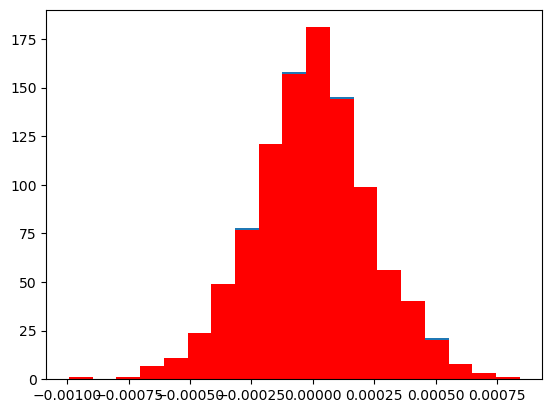

In [219]:
ax_x.bar(arr_bins_e_centers, counts_xe, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'red')
fig_x

<BarContainer object of 19 artists>

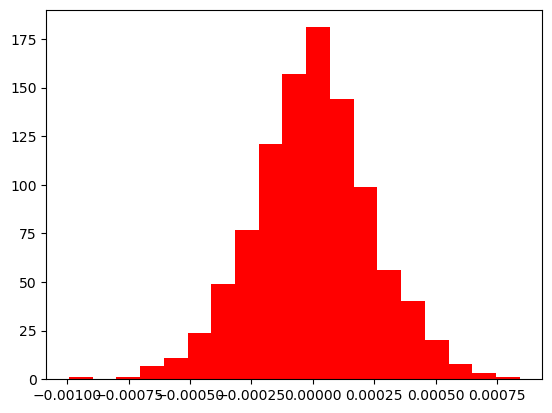

In [220]:
fig_x_e, ax_x_e = plt.subplots()
ax_x_e.bar(arr_bins_e_centers, counts_xe, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'red')

In [221]:
std = np.std(arr_vx)

In [222]:
std

0.00024088534922448064

In [223]:
tT = std**2 * dust_mass / cnst.k

In [224]:
tT

1209.50507734277

In [240]:
arr_resol = np.arange(1E-9,1E-6,1E-8)

In [241]:
arr_discrep = np.zeros(len(arr_resol))

In [242]:
for i in range(0, len(arr_resol)):
    res_i = arr_resol[i]
    df_i = create_art_vels(kin_Tx, kin_Ty, 1000, res_i, 100, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
    df_i_ff = df_i[df_i['frame'] == 1]
    std_i = np.std(df_i['vx'])
    tT = std_i**2 * dust_mass / cnst.k
    arr_discrep[i] = np.abs((kin_Tx - std_i**2 * dust_mass / cnst.k)) / kin_Tx
    

Text(0, 0.5, 'discrepancy (%)')

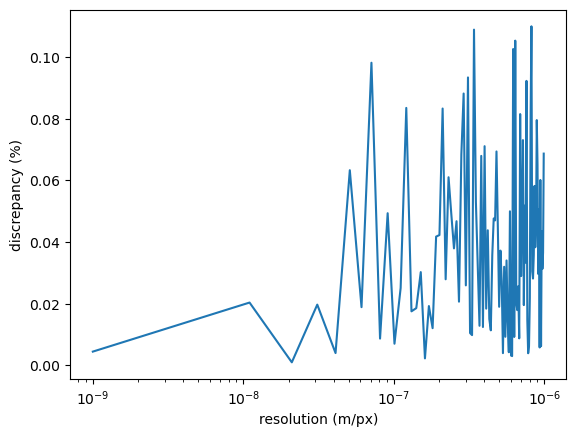

In [249]:
fig, ax = plt.subplots()
ax.plot(arr_resol, arr_discrep)
ax.set_xscale('log')
ax.set_xlabel('resolution (m/px)')
ax.set_ylabel("discrepancy (%)")